# Instructions


Check frames in `data/*vid_name*/` folders match `data/labels.csv` file.

You need 1:1 mapping between frame files and rows of `labels.csv` or the rest of the code in this package won't run. 

A mismatch might be caused by a difference in FPS in labels vs extracted frames or an issue in frame extraction or an issue in your labels file.

This notebook will do the check and help debug a mismatch between frame files and `labels.csv`

# Setup

In [2]:
import numpy as np
import cv2
from time import time as timer
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline

In [3]:
# setup paths
pwd = os.getcwd().replace("notebooks","")
path_videos = pwd + 'videos/'
path_data = pwd + 'data/'

In [4]:
# read video paths
paths = os.listdir(path_videos)
paths = [path_videos + v for v in paths if v != '.DS_Store']
paths

['/mnt/seals/videos/20150827_no8B_3.MOV',
 '/mnt/seals/videos/20150827_no8B_2.MOV',
 '/mnt/seals/videos/20160802_no8_1.MOV',
 '/mnt/seals/videos/20150827_no8B_1.MOV',
 '/mnt/seals/videos/20160802_no8_3.MOV',
 '/mnt/seals/videos/20160802_no8_2.MOV']

# Verify Frames Match Labels.csv

In [9]:
if not os.path.exists(pwd + 'data/labels.csv'):
    print("ERROR: labels.csv missing - please copy labels.csv to /data/labels.csv")
    print()
    print("Sample label file below:")    
    print("""video\t\t\tframe \t\t\t\t label
    20160801_no9_1\t\t20160801_no9_1_00001.jpeg	search
    20160801_no9_1\t\t20160801_no9_1_00002.jpeg	search
    ...""")
    print()
    print("Note you also need a 'split' column that assigns videos to train/valid/test splits - can use /notebooks/helper_add_train_valid_test_splits_to_labels.ipynb to add splits")

In [10]:
# load labels
labels = pd.read_csv(path_data + 'labels.csv')

In [11]:
labels.head()

,video,frame,label,split
0,20150807_no8B_1,20150807_no8B_1_00001.jpeg,shallow,train
1,20150807_no8B_1,20150807_no8B_1_00002.jpeg,shallow,train
2,20150807_no8B_1,20150807_no8B_1_00003.jpeg,shallow,train
3,20150807_no8B_1,20150807_no8B_1_00004.jpeg,shallow,train
4,20150807_no8B_1,20150807_no8B_1_00005.jpeg,shallow,train


In [12]:
# read frames paths
paths_videos = os.listdir(path_data)
paths_videos = [path_data + v + '/' for v in paths_videos if v != '.DS_Store' and v != 'labels.csv']

vids_error = []
vids_ok = []

# for path_video in paths_videos:    
for path_video in paths_videos:

    # get vid name from path
    vid_name = path_video[:-1].split("/")[-1]

    # convert list of frame files to dataframe
    paths_frames = os.listdir(path_video)
    paths_frames = [f for f in paths_frames if f != '.DS_Store']
    paths_frames = pd.DataFrame(paths_frames, columns = ['frame_file'])

    # subset labels to just this vid
    labels_vid = labels[labels['video'] == vid_name]

    # collect errors so can print grouped
    if not len(labels_vid) == len(paths_frames):
        vids_error.append("{} - Different number of labels ({}) than frames ({}) ... DIFF: {} ".format(vid_name, len(labels_vid),len(paths_frames), len(labels_vid) - len(paths_frames)))
    else:
        vids_ok.append("{} - Same number of labels and frames for vid".format(vid_name))
        
# print errors
print("ERRORS: {} VIDS WITH #LABELS != #FRAMES".format(len(vids_error)))
for msg in vids_error:
    print(msg)

print("\n")
print("OK: {} VIDS WITH #LABELS != #FRAMES".format(len(vids_ok)))
for msg in vids_ok:
    print(msg)

ERRORS: 21 VIDS WITH #LABELS != #FRAMES
20160930_no8_4 - Different number of labels (2814) than frames (2816) ... DIFF: -2 
20160929_no9_3 - Different number of labels (3634) than frames (3600) ... DIFF: 34 
20160819_no9_3 - Different number of labels (3598) than frames (3600) ... DIFF: -2 
20160812_no9_2 - Different number of labels (548) than frames (563) ... DIFF: -15 
20160929_no9_2 - Different number of labels (260) than frames (602) ... DIFF: -342 
20150827_no8B_3 - Different number of labels (3240) than frames (3241) ... DIFF: -1 
20160819_no9_2 - Different number of labels (576) than frames (558) ... DIFF: 18 
20150820_no8B_1 - Different number of labels (3698) than frames (3600) ... DIFF: 98 
20160802_no8_3 - Different number of labels (2702) than frames (2703) ... DIFF: -1 
20150827_no8B_2 - Different number of labels (580) than frames (566) ... DIFF: 14 
20160929_no9_4 - Different number of labels (3548) than frames (2816) ... DIFF: 732 
20160802_no8_2 - Different number of 

# Find last numbered frame for each video

In [ ]:
labels

# Find missing frames for a video

In [ ]:
# set video you want to visualize with labels - take this from the error output above
vid_name = "20160930_no8_4"

In [14]:
path_video = path_data + vid_name + '/'
print(path_video)

/mnt/seals/data/20160930_no8_4/


In [44]:
# convert list of frame files to dataframe
paths_frames = os.listdir(path_video)
paths_frames = [f for f in paths_frames if f != '.DS_Store']
paths_frames = pd.DataFrame(paths_frames, columns = ['frame_file'])
paths_frames.sort_values('frame_file', inplace=True)

In [65]:
# figure out which frames we're missing
labels_vid = labels[labels['video'] == vid_name]

In [66]:
labels_vid = pd.merge(labels_vid,paths_frames,left_on='frame', right_on='frame_file',how='left')

In [69]:
labels_vid[labels_vid['frame_file'].isnull()]

Empty DataFrame
Columns: [video, frame, label, split, frame_file]
Index: []


# Plot frames with labels for a video

In [108]:
def plot_video_with_labels(vid_name, index_to_start, index_to_end):
    """
    Plot frames of video with label from index_to_start to index_to_end
    
    :video_name: name of video (matches folder containing video's frames in /data/)
    :index_to_start: frame to start plotting from
    :index_to_end: frame to end on
    """

    assert (index_to_start<index_to_end), "ERROR: must input index_to_end > index_to_start"

    path_video = path_data + vid_name + '/'

    # convert list of frame files to dataframe
    print(path_video)
    paths_frames = os.listdir(path_video)
    paths_frames = [f for f in paths_frames if f != '.DS_Store']
    paths_frames = pd.DataFrame(paths_frames, columns = ['frame_file'])
    paths_frames.sort_values('frame_file', inplace=True)
    
    assert (index_to_end <= len(paths_frames)), "ERROR: index_to_end greater than number of frames"
    
    # get labels for this vid
    labels_vid = labels[labels['video'] == vid_name]
    
    for i,row in enumerate(labels_vid.values):
        if i >= index_to_start and i <= index_to_end:
            # get dict for df row
            rr = dict(zip(labels_vid.columns, row))

            # print label with plotted image
            print(rr['label'], '\t\t', rr['frame'])
            plt.imshow(Image.open(path_data + rr['video'] + '/' + rr['frame']))
            plt.show()

/mnt/seals/data/20160929_no9_3/
search 		 20160929_no9_3_003411.jpg


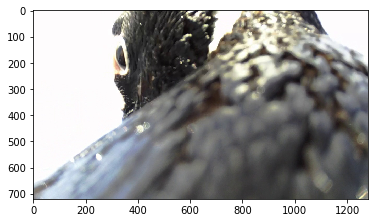

search 		 20160929_no9_3_003412.jpg


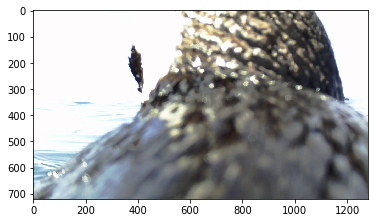

search 		 20160929_no9_3_003413.jpg


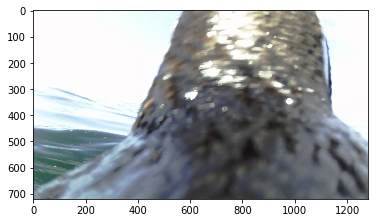

search 		 20160929_no9_3_003414.jpg


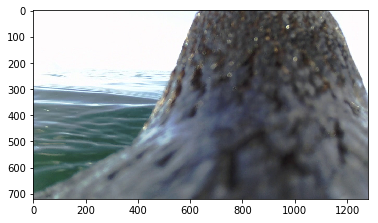

search 		 20160929_no9_3_003415.jpg


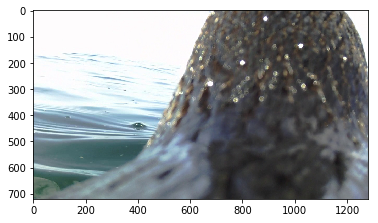

search 		 20160929_no9_3_003416.jpg


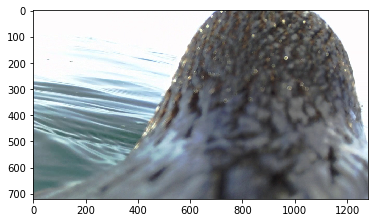

descent 		 20160929_no9_3_003417.jpg


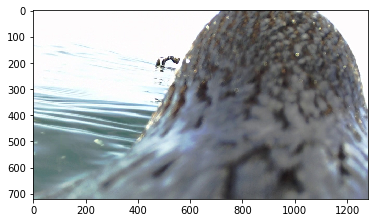

descent 		 20160929_no9_3_003418.jpg


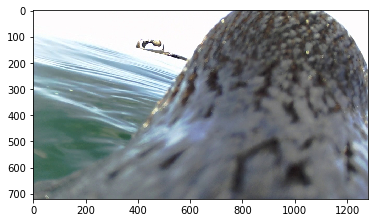

descent 		 20160929_no9_3_003419.jpg


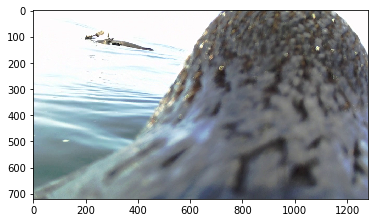

descent 		 20160929_no9_3_003420.jpg


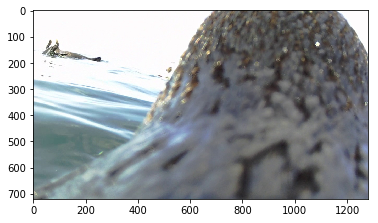

descent 		 20160929_no9_3_003421.jpg


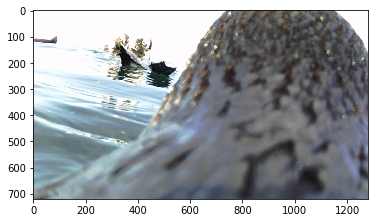

descent 		 20160929_no9_3_003422.jpg


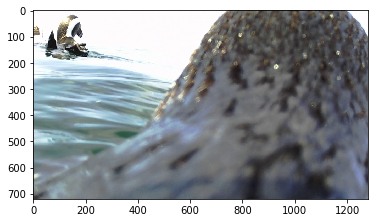

descent 		 20160929_no9_3_003423.jpg


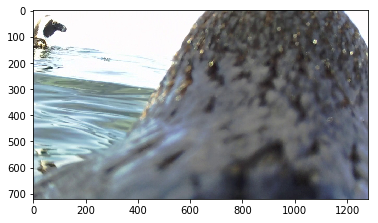

descent 		 20160929_no9_3_003424.jpg


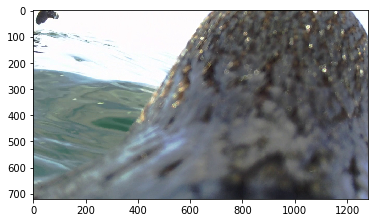

descent 		 20160929_no9_3_003425.jpg


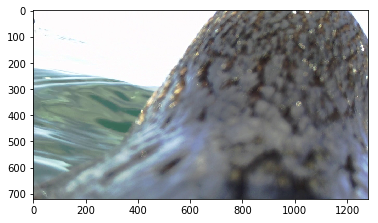

descent 		 20160929_no9_3_003426.jpg


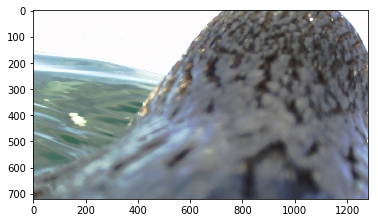

descent 		 20160929_no9_3_003427.jpg


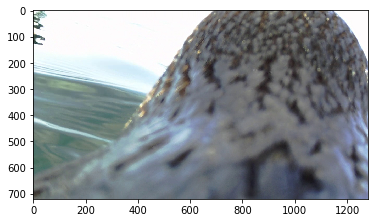

descent 		 20160929_no9_3_003428.jpg


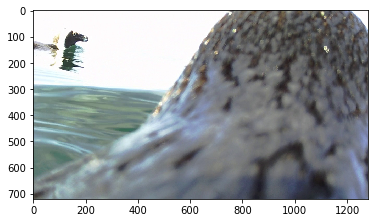

descent 		 20160929_no9_3_003429.jpg


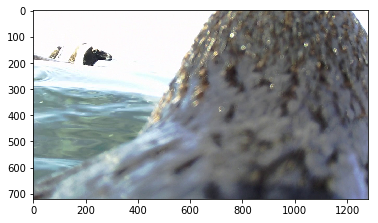

descent 		 20160929_no9_3_003430.jpg


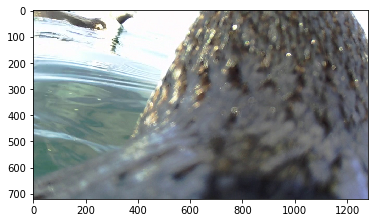

descent 		 20160929_no9_3_003431.jpg


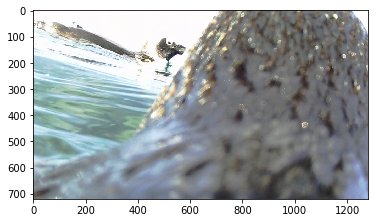

In [109]:
plot_video_with_labels("20160929_no9_3",3410,3430)

# Clean up labels

In [99]:
# run this cell to remove a video from labels and update labels.csv
video_to_remove_from_labels = '20160929_no9_2'
labels = labels[labels['video'] != video_to_remove_from_labels]
labels.to_csv(path_data + 'labels.csv', index=False)

In [100]:
# reload labels file
labels = pd.read_csv(path_data + 'labels.csv')
labels.head()

,video,frame,label,split
0,20150807_no8B_1,20150807_no8B_1_000001.jpg,shallow,train
1,20150807_no8B_1,20150807_no8B_1_000002.jpg,shallow,train
2,20150807_no8B_1,20150807_no8B_1_000003.jpg,shallow,train
3,20150807_no8B_1,20150807_no8B_1_000004.jpg,shallow,train
4,20150807_no8B_1,20150807_no8B_1_000005.jpg,shallow,train
